In [1]:
import sys
sys.path.append('../../../lib')
from tqdm import tqdm
from scipy.signal import fftconvolve
import numpy as np

from PIL import Image
import os
import matplotlib.pyplot as plt
from fast_detection_methods import trajectory_gauss, trajectory_mean, trajectory_corr, fit_gaussian, find_ideal_R,most_common_value
from movie_processing import movie_to_array, clean_problem_pixels
#from pipython.datarectools import getservotime
import cv2
#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

In [2]:
pip install dill

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install git+https://github.com/wusche1/SpectralMechanicsAnalysis.git

  Cloning https://github.com/wusche1/SpectralMechanicsAnalysis.git to c:\users\jschulz\appdata\local\temp\pip-req-build-sa0itxgw
  Resolved https://github.com/wusche1/SpectralMechanicsAnalysis.git to commit 50aa956831376f2ab3a16c916097821941e2df89
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for SpectralMechanicsAnalysis: filename=SpectralMechanicsAnalysis-0.1.0-py3-none-any.whl size=13180 sha256=22305f9028c6268b82a4c313a9184265abeca04ea37edbf6937ca27793eaef68
  Stored in directory: C:\Users\jschulz\AppData\Local\Temp\pip-ephem-wheel-cache-uh21dcrz\wheels\6f\d7\cd\10dba822cabc598fb679da

  Running command git clone --filter=blob:none --quiet https://github.com/wusche1/SpectralMechanicsAnalysis.git 'C:\Users\jschulz\AppData\Local\Temp\pip-req-build-sa0itxgw'


In [2]:
from SpectralMechanicsAnalysis import Data, mean_back_realxation, mean_back_relaxation_multiple_trajectories, mean_back_relaxation_multiple_trajectories_with_timestamps, mean_back_relaxation_multiple_trajectories_with_timestamps
from SpectralMechanicsAnalysis.data_handeling import load_data

In [3]:
data_path = r'\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24'
samples = os.listdir(data_path)
two_khz_path_list = [os.path.join(data_path, sample, '2_kHz.avi') for sample in samples]
two_khz_path_list = [path for path in two_khz_path_list if os.path.exists(path)]

ten_khz_path_list = [os.path.join(data_path, sample, '10_kHz.avi') for sample in samples]
ten_khz_path_list = [path for path in ten_khz_path_list if os.path.exists(path)]

In [6]:
ten_khz_path_list

['\\\\134.76.13.158\\betzlab\\Julian\\cell_beats\\11_03_24\\sample_4\\10_kHz.avi',
 '\\\\134.76.13.158\\betzlab\\Julian\\cell_beats\\11_03_24\\sample_5\\10_kHz.avi',
 '\\\\134.76.13.158\\betzlab\\Julian\\cell_beats\\11_03_24\\sample_6\\10_kHz.avi']

In [4]:
for path in ten_khz_path_list:
    print(path)

    path_to_current_folder = os.path.dirname(path)
    trajectory_folder_path = os.path.join(path_to_current_folder, '10_khz_trajectories')
    if not os.path.exists(trajectory_folder_path):
        numpy_movie = movie_to_array(path)
        numpy_movie = clean_problem_pixels(numpy_movie)
        numpy_movie -= most_common_value(numpy_movie)
        print(numpy_movie.shape)
        os.makedirs(trajectory_folder_path)
        tra_mean = trajectory_mean(numpy_movie, logging_enabled=True)
        tra_gauss = trajectory_gauss(numpy_movie)
        #tra_corr = trajectory_corr(numpy_movie)
        np.save(os.path.join(trajectory_folder_path, 'tra_mean.npy'), tra_mean)	
        np.save(os.path.join(trajectory_folder_path, 'tra_gauss.npy'), tra_gauss)
        #np.save(os.path.join(trajectory_folder_path, 'tra_corr.npy'), tra_corr)
    else:
        print('Trajectories already exist')

\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_4\10_kHz.avi
Trajectories already exist
\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_5\10_kHz.avi
Trajectories already exist
\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_6\10_kHz.avi
Trajectories already exist


In [25]:
data_list = []
for path in ten_khz_path_list:
    print(path)
    tra_mean = np.load(os.path.join(os.path.dirname(path), '10_khz_trajectories', 'tra_mean.npy'))
    tra_gauss = np.load(os.path.join(os.path.dirname(path), '10_khz_trajectories', 'tra_gauss.npy'))
    #tra_corr = np.load(os.path.join(os.path.dirname(path), '2_khz_trajectories', 'tra_corr.npy'))

    x_data = tra_gauss[:,0]
    y_data = tra_gauss[:,1]
    t_data = np.linspace(0, len(x_data)/(1000*10), len(x_data))

    data_list.append(Data(t_data, x_data, typical_peak_number=1, max_peak_percentage=.9, log_weighted=True, unweighted_postfit = True))
    data_list.append(Data(t_data, y_data, typical_peak_number=1, max_peak_percentage=.9, log_weighted=True, unweighted_postfit = True))

\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_4\10_kHz.avi
\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_5\10_kHz.avi
\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_6\10_kHz.avi


In [35]:
for i, data in enumerate(data_list):
    t_data = np.linspace(0, len(data.x)/(1000*10), len(data.x))
    data_list[i] = Data(t_data, data.x, typical_peak_number=1, max_peak_percentage=.9, log_weighted=True, unweighted_postfit = True)

In [36]:
for data in data_list:
    data.bayesian_update()

In [37]:
for data in data_list:
    print(f"Posterior maxwell: {data.posterior_maxwell}")
    print(f"Posterior kelvin_voigt: {data.posterior_kelvin_voigt}")
    print(f"Posterior fractional kelvin_voigt: {data.posterior_fractional_kelvin_voigt}")

Posterior maxwell: 0.0
Posterior kelvin_voigt: 0.0
Posterior fractional kelvin_voigt: 1.0
Posterior maxwell: 0.0
Posterior kelvin_voigt: 0.0
Posterior fractional kelvin_voigt: 1.0
Posterior maxwell: 0.0
Posterior kelvin_voigt: 0.0
Posterior fractional kelvin_voigt: 1.0
Posterior maxwell: 0.0
Posterior kelvin_voigt: 0.0
Posterior fractional kelvin_voigt: 1.0
Posterior maxwell: 0.0
Posterior kelvin_voigt: 0.0
Posterior fractional kelvin_voigt: 1.0
Posterior maxwell: 0.0
Posterior kelvin_voigt: 0.0
Posterior fractional kelvin_voigt: 1.0


In [38]:
for data in data_list:
    print(1)
    data.peaks = []
    data.max_peak_percentage = 0.8
    data.find_peaks(max_iter=5)

1
1
1
1
1
1


In [46]:
for data in data_list:
    data.create_reconstructed_data()

In [39]:
for i, data in enumerate(data_list):
    path_number = int(i/2)
    path = ten_khz_path_list[path_number]
    letter = 'x' if i%2 == 0 else 'y'
    data.save(os.path.join(os.path.dirname(path), '10_khz_trajectories', 'data' +letter + '.pkl'))


In [41]:
#load data
data_list = []
for path in ten_khz_path_list:
    data_list.append(load_data(os.path.join(os.path.dirname(path), '10_khz_trajectories', 'datax.pkl')))
    data_list.append(load_data(os.path.join(os.path.dirname(path), '10_khz_trajectories', 'datay.pkl')))

In [48]:

def mean_back_realxation(dt, trajectory, Tao, timespan, multiplier=1, d_sigma_estimation_samples = 1000, return_n_points_added=False, progress_bar = True, min_cutoff = 0):
    if isinstance(trajectory, list):
        trajectory = np.array(trajectory, dtype=np.float64)  # Ensure high precision
    forward_sampling = int(timespan / dt)
    backward_sampling = int(Tao / dt)

    d_array = trajectory[backward_sampling:] - trajectory[:-backward_sampling]

    # Estimate the standard deviation of the d array
    d_sample = np.random.choice(d_array, size=min(d_sigma_estimation_samples, len(d_array)), replace=False)
    d_sigma = np.std(d_sample)
    d_cutoff = d_sigma * multiplier

    if d_cutoff < min_cutoff:
        print(f"Warning: d_cutoff is smaller than min_cutoff. Setting d_cutoff {d_cutoff} = min_cutoff {min_cutoff}")
        d_cutoff = min_cutoff
    else:
        print(f"d_cutoff: {d_cutoff}, min_cutoff: {min_cutoff}")    

    valid_points = np.abs(d_array) > d_cutoff
    valid_indices = np.where(valid_points[:-forward_sampling])[0]

    # Initialize an accumulator for the samples with high precision
    sample_accumulator = np.zeros(forward_sampling, dtype=np.float64)

    n_points_added = 0

    # Iterate over the valid indices and accumulate the samples. make a progress bar if progress_bar is True
    for idx in tqdm(valid_indices, disable=not progress_bar, total=len(valid_indices)):
        sample = trajectory[idx + backward_sampling : idx + backward_sampling + forward_sampling] - trajectory[idx + backward_sampling]
        d_mbr = d_array[idx]
        sample_to_add = (-sample / d_mbr).astype(np.float64)  # Ensure high precision
        
        # Accumulate the samples directly
        sample_accumulator += sample_to_add
        n_points_added += 1

    # Normalize the accumulated samples by the total number of points added
    if n_points_added > 0:  # Avoid division by zero
        mbr_trajectory = sample_accumulator / n_points_added
    else:
        # Handle case with no valid points added
        mbr_trajectory = np.zeros(forward_sampling, dtype=np.float64)  # or an appropriate default/fallback value

    if return_n_points_added:
        return mbr_trajectory, n_points_added
    else:
        return mbr_trajectory

In [49]:
dt = 1/10000
T = .5
tau_list = np.array([1,2,5,10,20,50,100])*dt
mbr_list = [[] for _ in data_list]
mbr_longtime_list = [[] for _ in data_list]
for i, data in enumerate(data_list):
    for j, tau in enumerate(tau_list):
        error_in_pixels = np.sqrt(np.mean(data.PSD[-100:]))
        mbr = mean_back_realxation(dt,data.reconstructed_x, tau, T, min_cutoff = error_in_pixels)
        mbr_list[i].append(mbr)
        
        second_half_mbr = mbr[int(len(mbr)/2):]
        mean_second_half_mbr = np.mean(second_half_mbr)
        std_second_half_mbr = np.std(second_half_mbr)
        mbr_longtime_list[i].append((mean_second_half_mbr, std_second_half_mbr))
t_mbr = np.linspace(0, len(mbr_list[0][0])*dt, len(mbr_list[0][0]))

d_cutoff: 0.02550418923413839, min_cutoff: 0.015016910380832124


100%|██████████| 62635/62635 [00:00<00:00, 110128.00it/s]


d_cutoff: 0.029519340592088553, min_cutoff: 0.015016910380832124


100%|██████████| 67378/67378 [00:00<00:00, 115350.19it/s]


d_cutoff: 0.03758603312431763, min_cutoff: 0.015016910380832124


100%|██████████| 64118/64118 [00:00<00:00, 113142.00it/s]


d_cutoff: 0.04311462068314514, min_cutoff: 0.015016910380832124


100%|██████████| 63373/63373 [00:00<00:00, 112094.06it/s]


d_cutoff: 0.04833919007440056, min_cutoff: 0.015016910380832124


100%|██████████| 64320/64320 [00:00<00:00, 112440.42it/s]


d_cutoff: 0.055694825410161304, min_cutoff: 0.015016910380832124


100%|██████████| 63396/63396 [00:00<00:00, 111088.78it/s]


d_cutoff: 0.06155620633558527, min_cutoff: 0.015016910380832124


100%|██████████| 61428/61428 [00:00<00:00, 102313.46it/s]


d_cutoff: 0.025774833907402837, min_cutoff: 0.014539211536087846


100%|██████████| 63443/63443 [00:00<00:00, 108724.47it/s]


d_cutoff: 0.031794250050510446, min_cutoff: 0.014539211536087846


100%|██████████| 61679/61679 [00:00<00:00, 111198.05it/s]


d_cutoff: 0.037952824423353064, min_cutoff: 0.014539211536087846


100%|██████████| 64327/64327 [00:00<00:00, 104275.73it/s]


d_cutoff: 0.044977655551395525, min_cutoff: 0.014539211536087846


100%|██████████| 61422/61422 [00:00<00:00, 104887.44it/s]


d_cutoff: 0.05071569166415253, min_cutoff: 0.014539211536087846


100%|██████████| 62734/62734 [00:00<00:00, 114194.34it/s]


d_cutoff: 0.06007125572522879, min_cutoff: 0.014539211536087846


100%|██████████| 60230/60230 [00:00<00:00, 102581.45it/s]


d_cutoff: 0.06598136396162028, min_cutoff: 0.014539211536087846


100%|██████████| 61023/61023 [00:00<00:00, 109888.18it/s]


d_cutoff: 0.0318964260967255, min_cutoff: 0.01687065581935186


100%|██████████| 96823/96823 [00:00<00:00, 113662.88it/s]


d_cutoff: 0.0365054861920074, min_cutoff: 0.01687065581935186


100%|██████████| 98172/98172 [00:00<00:00, 106836.93it/s]


d_cutoff: 0.04208196870451181, min_cutoff: 0.01687065581935186


100%|██████████| 104247/104247 [00:00<00:00, 114359.41it/s]


d_cutoff: 0.04811936568618183, min_cutoff: 0.01687065581935186


100%|██████████| 104186/104186 [00:00<00:00, 115681.58it/s]


d_cutoff: 0.053963412860803, min_cutoff: 0.01687065581935186


100%|██████████| 106141/106141 [00:00<00:00, 115797.40it/s]


d_cutoff: 0.06608020120988586, min_cutoff: 0.01687065581935186


100%|██████████| 99350/99350 [00:00<00:00, 113556.78it/s]


d_cutoff: 0.0696583890221358, min_cutoff: 0.01687065581935186


100%|██████████| 105388/105388 [00:00<00:00, 111103.20it/s]


d_cutoff: 0.027512884833917214, min_cutoff: 0.016108342492321


100%|██████████| 103337/103337 [00:00<00:00, 108748.68it/s]


d_cutoff: 0.03425267874822689, min_cutoff: 0.016108342492321


100%|██████████| 99432/99432 [00:00<00:00, 115677.59it/s]


d_cutoff: 0.04248762889012217, min_cutoff: 0.016108342492321


100%|██████████| 99748/99748 [00:00<00:00, 113073.90it/s]


d_cutoff: 0.04672929366930852, min_cutoff: 0.016108342492321


100%|██████████| 108114/108114 [00:00<00:00, 112902.34it/s]


d_cutoff: 0.054757262425730674, min_cutoff: 0.016108342492321


100%|██████████| 103983/103983 [00:00<00:00, 119142.22it/s]


d_cutoff: 0.06312300712224515, min_cutoff: 0.016108342492321


100%|██████████| 107067/107067 [00:01<00:00, 106660.53it/s]


d_cutoff: 0.07017337322607228, min_cutoff: 0.016108342492321


100%|██████████| 104940/104940 [00:00<00:00, 110550.71it/s]


d_cutoff: 0.027576498570783318, min_cutoff: 0.014763638438137463


100%|██████████| 204175/204175 [00:01<00:00, 114471.48it/s]


d_cutoff: 0.03730556768097947, min_cutoff: 0.014763638438137463


100%|██████████| 192451/192451 [00:01<00:00, 111257.24it/s]


d_cutoff: 0.05142069236612299, min_cutoff: 0.014763638438137463


100%|██████████| 177599/177599 [00:01<00:00, 107985.43it/s]


d_cutoff: 0.05647800349191215, min_cutoff: 0.014763638438137463


100%|██████████| 202936/202936 [00:01<00:00, 115864.55it/s]


d_cutoff: 0.07126678262725944, min_cutoff: 0.014763638438137463


100%|██████████| 181792/181792 [00:01<00:00, 112551.06it/s]


d_cutoff: 0.08239189089683904, min_cutoff: 0.014763638438137463


100%|██████████| 196504/196504 [00:01<00:00, 112124.96it/s]


d_cutoff: 0.09114620690288004, min_cutoff: 0.014763638438137463


100%|██████████| 203473/203473 [00:01<00:00, 111282.34it/s]


d_cutoff: 0.02807407748048156, min_cutoff: 0.016755093947994685


100%|██████████| 208850/208850 [00:01<00:00, 108984.36it/s]


d_cutoff: 0.03827429906453891, min_cutoff: 0.016755093947994685


100%|██████████| 197591/197591 [00:01<00:00, 109977.58it/s]


d_cutoff: 0.049286507360460766, min_cutoff: 0.016755093947994685


100%|██████████| 203306/203306 [00:01<00:00, 116171.88it/s]


d_cutoff: 0.06039122321702264, min_cutoff: 0.016755093947994685


100%|██████████| 194809/194809 [00:01<00:00, 112752.90it/s]


d_cutoff: 0.06957881717220556, min_cutoff: 0.016755093947994685


100%|██████████| 198376/198376 [00:01<00:00, 110762.12it/s]


d_cutoff: 0.08401755026674733, min_cutoff: 0.016755093947994685


100%|██████████| 191593/191593 [00:01<00:00, 112784.38it/s]


d_cutoff: 0.09330781805671468, min_cutoff: 0.016755093947994685


100%|██████████| 192401/192401 [00:01<00:00, 111106.61it/s]


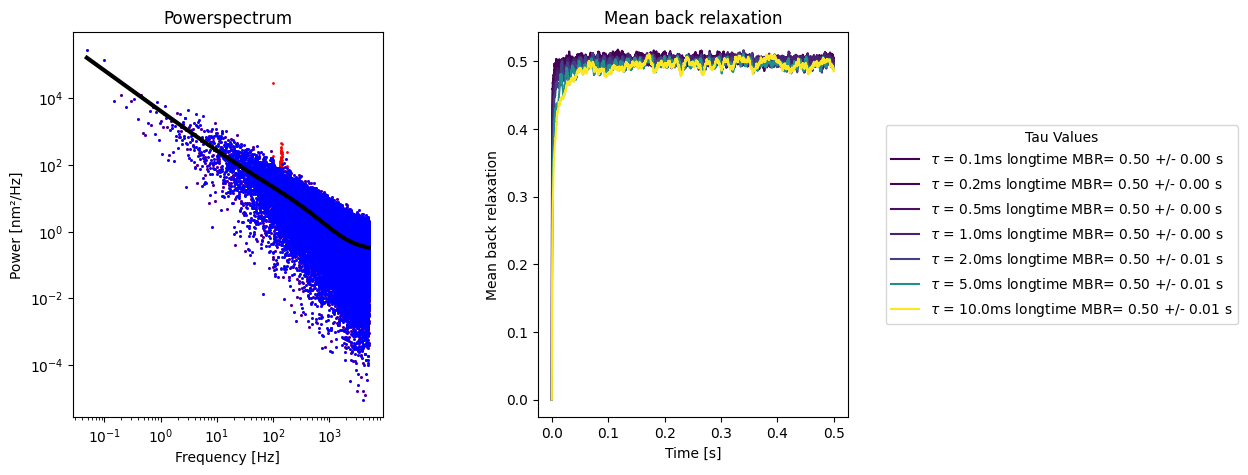

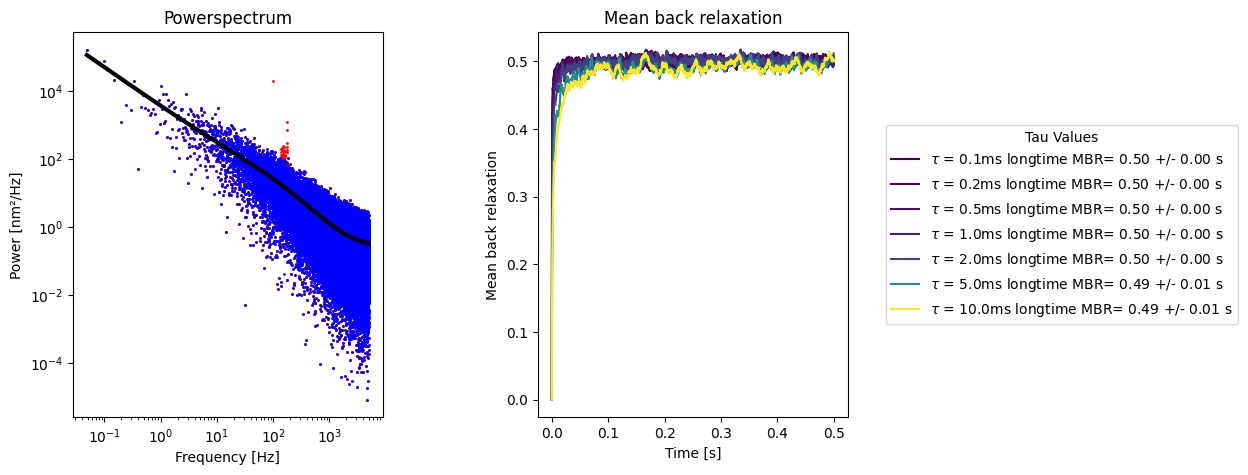

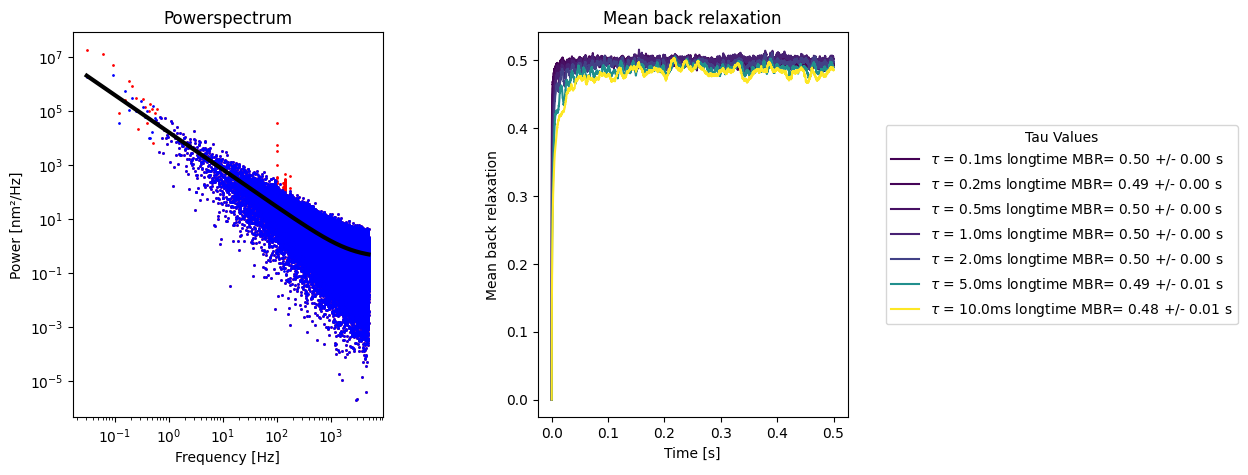

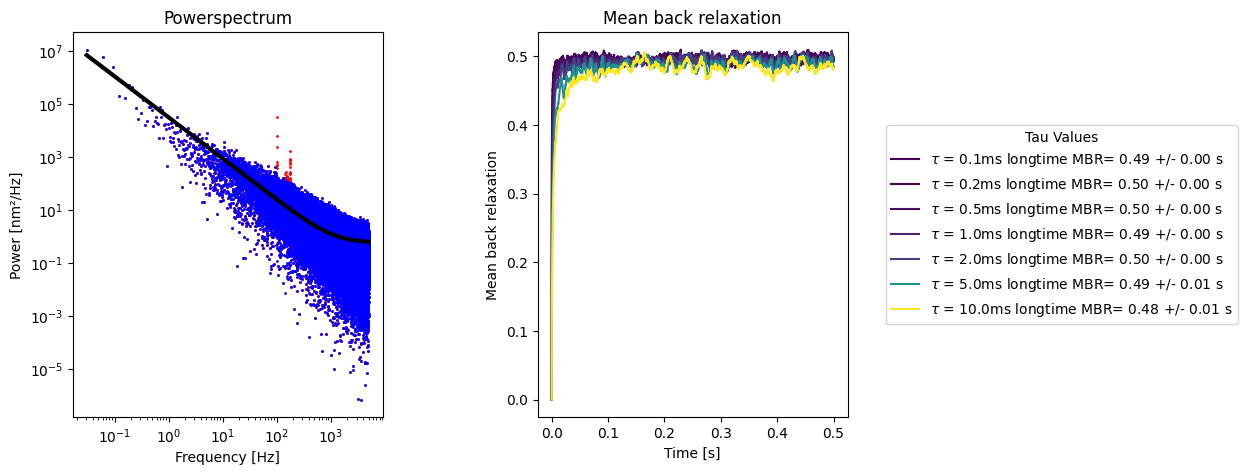

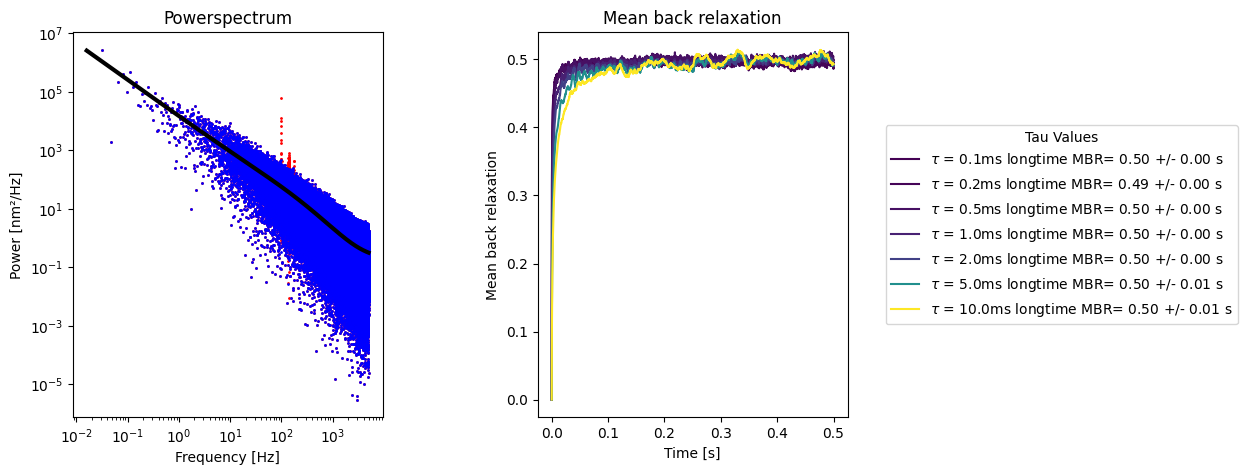

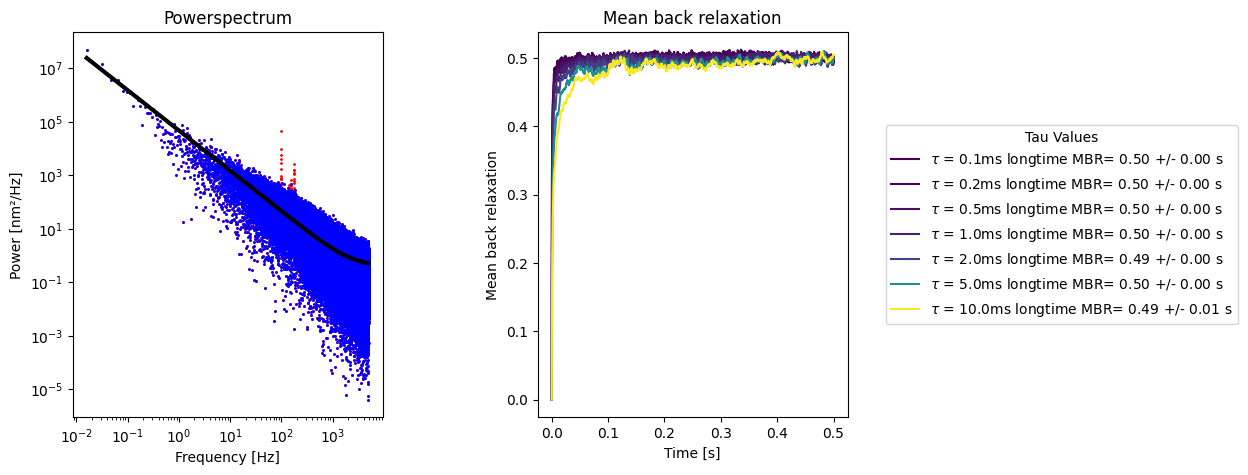

In [53]:
nm_pro_pixel = 0.036768956332537246 * 1000
cmap = plt.cm.viridis  # You can choose any available colormap
norm = plt.Normalize(min(tau_list), max(tau_list))
for data, mbr_selection, longtime_mbr_selection in zip(data_list, mbr_list, mbr_longtime_list):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].scatter(data.frequencies, data.PSD* nm_pro_pixel**2, color = 'red', s = 1)
    ax[0].scatter(data.frequencies, data.reconstructed_PSD* nm_pro_pixel**2, color = 'blue', s = 1)
    ax[0].plot(data.frequencies, data.fit_function(data.frequencies, data.fit_params)* nm_pro_pixel**2, color = 'black', linewidth = 3)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Powerspectrum')
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Power [nm²/Hz]')


    for tau, mbr, longtime_mbr in zip(tau_list, mbr_selection, longtime_mbr_selection):
        color = cmap(norm(tau))
        ax[1].plot(t_mbr, mbr, color=color, label=f'$\\tau$ = {tau*1000}ms longtime MBR= {longtime_mbr[0]:.2f} +/- {longtime_mbr[1]:.2f} s')
    ax[1].set_title('Mean back relaxation')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Mean back relaxation')
    ax[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), title="Tau Values")

    # put distnace between the two plots
    plt.subplots_adjust(wspace=0.5)
    
    


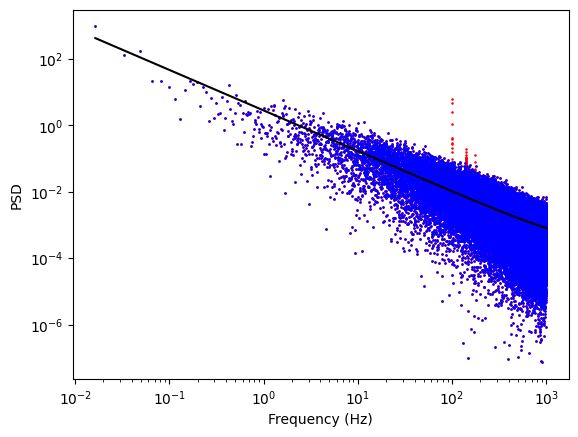

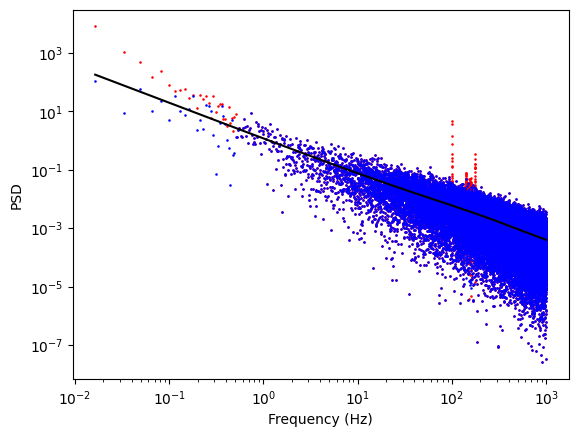

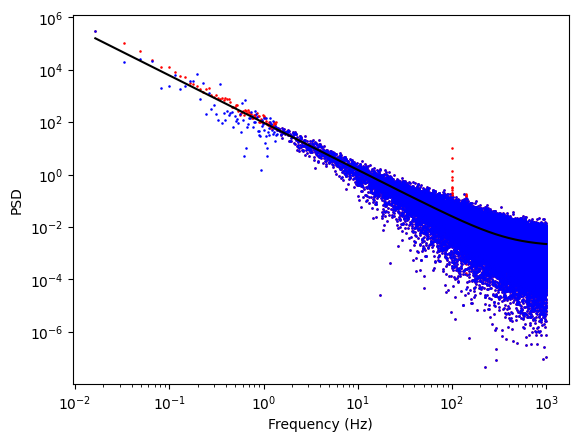

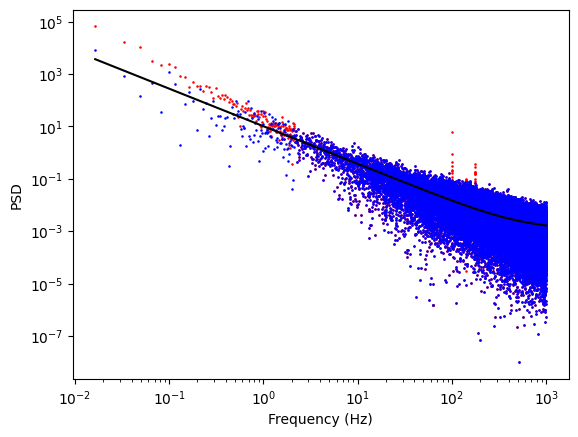

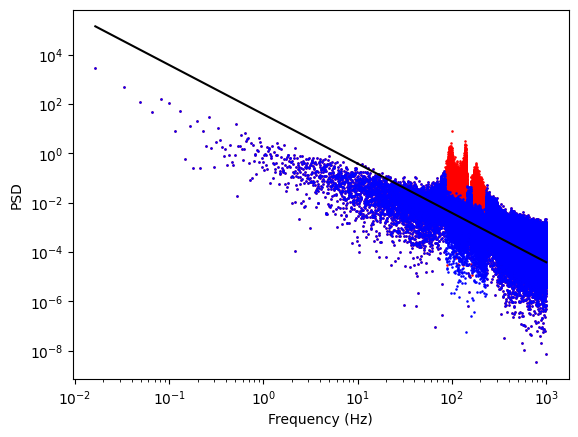

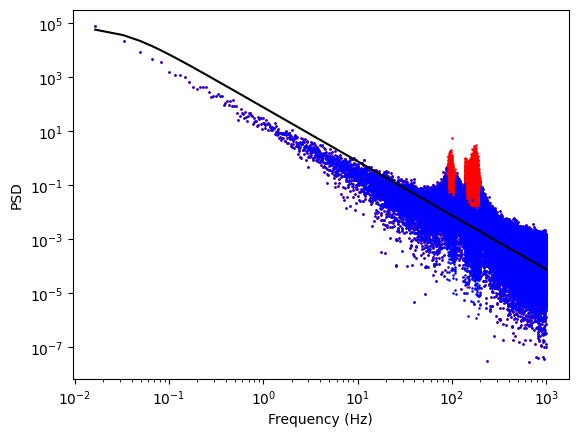

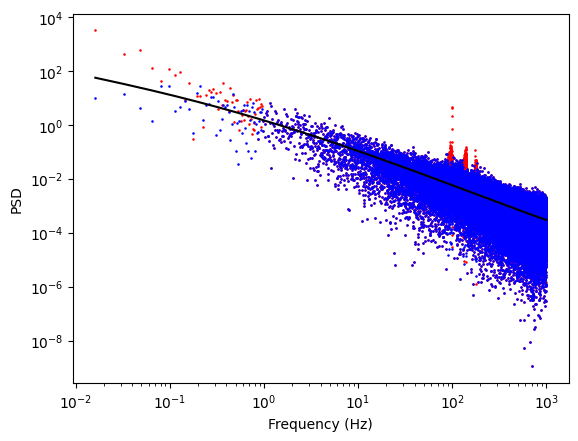

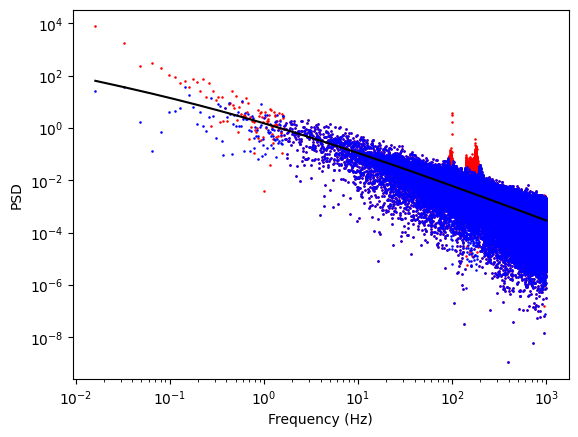

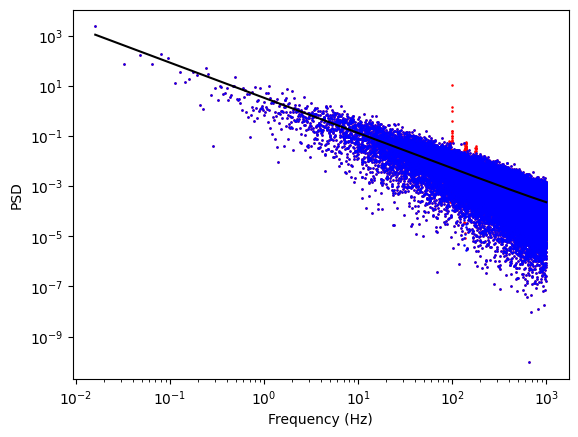

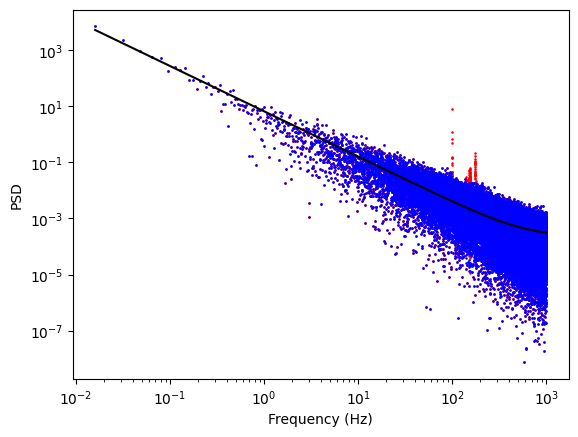

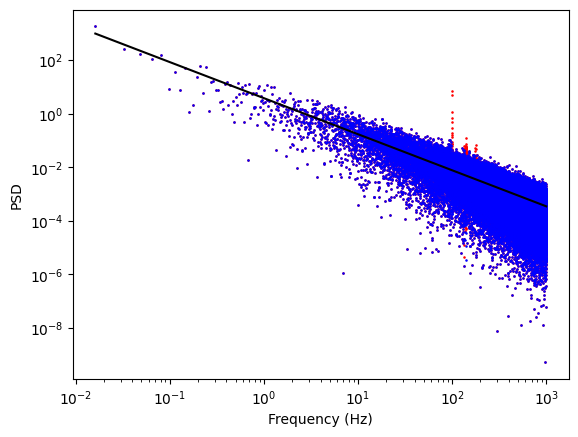

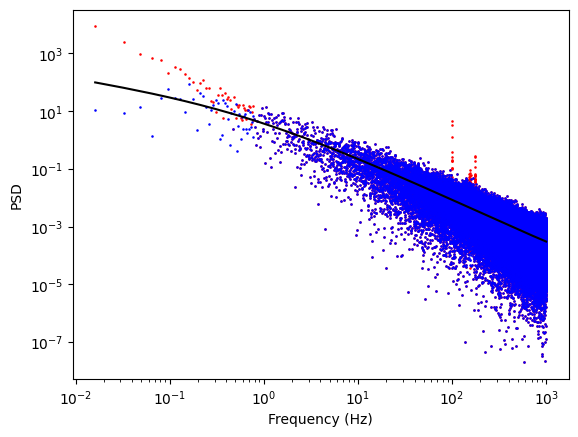

In [18]:
for data in data_list:
    frequencies = data.frequencies
    PSD = data.PSD
    plt.scatter(frequencies, PSD, s=.7,c='r')
    plt.scatter(frequencies, data.reconstructed_PSD, c='b', s=.7)
    plt.plot(frequencies, data.fit_function(frequencies, data.fit_params), c='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.show()

In [19]:
dt = 1/2000
T = .5
def E_0_over_kb_T(longtime_MBR):
    return longtime_MBR*(-96.575)+46.93
tau_list = np.array([1,2,5,10,20,50,100])*dt
mbr_list = [[] for tau in tau_list]
for data in data_list:
    for i, tau in enumerate(tau_list):
        mbr = mean_back_realxation(dt,data.reconstructed_x, tau, T)
        mbr_list[i].append(mbr)
        if i == 0:
            second_half_mbr = mbr[int(len(mbr)/2):]
            mean_second_half_mbr = np.mean(second_half_mbr)
            std_second_half_mbr = np.std(second_half_mbr)
            #check wether .5 is in the one sigma interval
            if not (mean_second_half_mbr - std_second_half_mbr < .5 and mean_second_half_mbr + std_second_half_mbr > .5):
                E_0 =E_0_over_kb_T(mean_second_half_mbr)
                data.create_activity_filtered_PSD(E_0)
t_mbr = np.linspace(0, len(mbr_list[0][0])*dt, len(mbr_list[0][0]))

  0%|          | 0/39095 [00:00<?, ?it/s]

100%|██████████| 33346/33346 [00:00<00:00, 227856.75it/s]
c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\.venv\Lib\site-packages\SpectralMechanicsAnalysis\analyze_data.py:189: RuntimeWarning: overflow encountered in exp
  params = [np.exp(params[0]),np.exp(params[1]),sigmoid(params[2]),sigmoid(params[3]),np.exp(params[4])]
c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\.venv\Lib\site-packages\SpectralMechanicsAnalysis\models.py:15: RuntimeWarning: invalid value encountered in divide
  psd = np.where(omega == 0, 0, -2 * kbT / omega * np.imag(1/G(omega, *G_args)) + noise)
c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\.venv\Lib\site-packages\SpectralMechanicsAnalysis\analyze_data.py:36: RuntimeWarning: overflow encountered in divide
  Loss = y_data / y_model + np.log(y_model)
c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, ou

In [20]:
best_data = data_list[2]
one_khz_mbr =  mbr_list[1][2]
longtime_mbr = np.mean(one_khz_mbr[-100:])
E_0 = E_0_over_kb_T(longtime_mbr)
best_data.create_activity_filtered_PSD(E_0)


In [21]:
best_data_path = two_khz_path_list[2]
best_data_path

'\\\\134.76.13.158\\betzlab\\Julian\\cell_beats\\11_03_24\\sample_3\\2_kHz.avi'

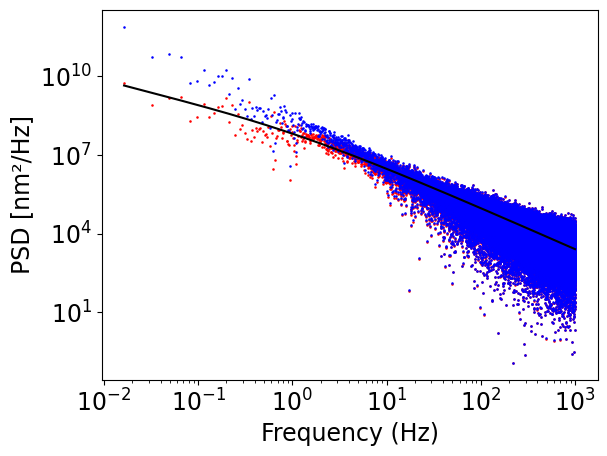

A = 1.0049218025253158e-16
B = 6.793543635382225e-05
alpha = 0.51
beta = 0.80
sigma = 0.0018695800657143797
A = 9.4846112815888e-05
B = 7.32410407869314e-05
alpha = 0.59
beta = 0.08
sigma = 6.74176653456305e-17


<Figure size 640x480 with 0 Axes>

In [23]:
nm_pro_pixel = (0.036768956332537246 * 1000)**2
plt.rcParams.update({'font.size': 17})
plt.scatter(best_data.frequencies, best_data.activity_filtered_PSD/dt*nm_pro_pixel, s=.7,c='r')
plt.scatter(best_data.frequencies, best_data.reconstructed_PSD/dt*nm_pro_pixel, c='b', s=.7)
plt.plot(best_data.frequencies, data.fit_function(best_data.frequencies, best_data.activity_filtered_fit_params)/dt*nm_pro_pixel, c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD [nm\u00b2/Hz]")
plt.show()
kb_T = 293
for params in [best_data.fit_params, best_data.activity_filtered_fit_params]:
    A_T,B_T,alpha,beta,sigma = params
    print(f"A = {A_T/kb_T}")
    print(f"B = {B_T/kb_T}")
    print(f"alpha = {alpha:.2f}")
    print(f"beta = {beta:.2f}")
    print(f"sigma = {sigma}")
plt.savefig(r'C:\Users\jschulz\Desktop\energy-correction.png', format='png', dpi=1000)


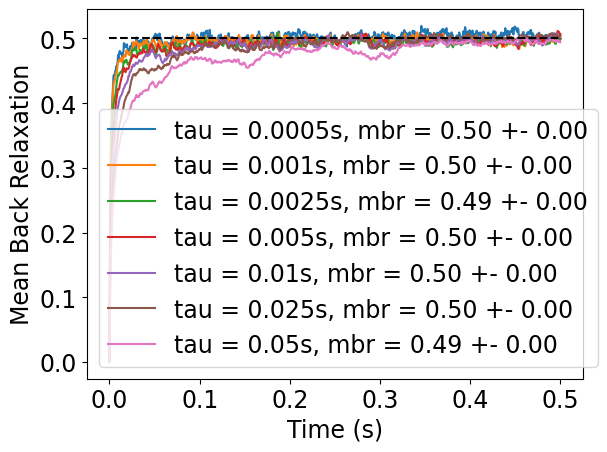

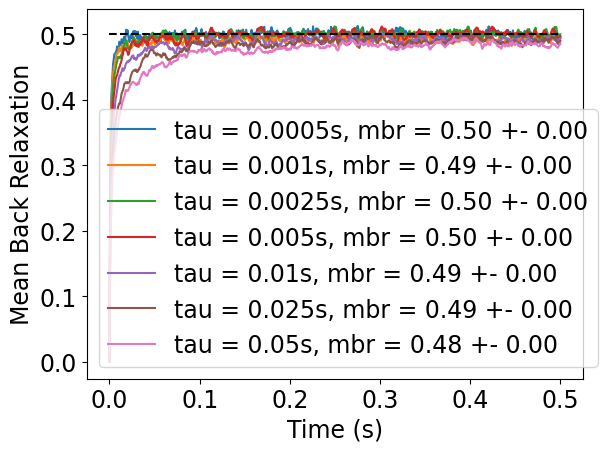

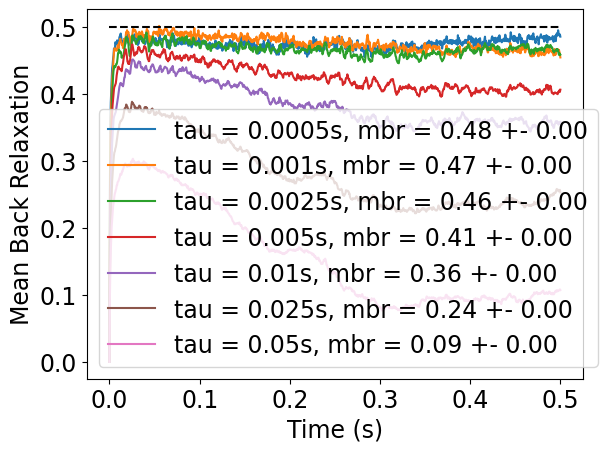

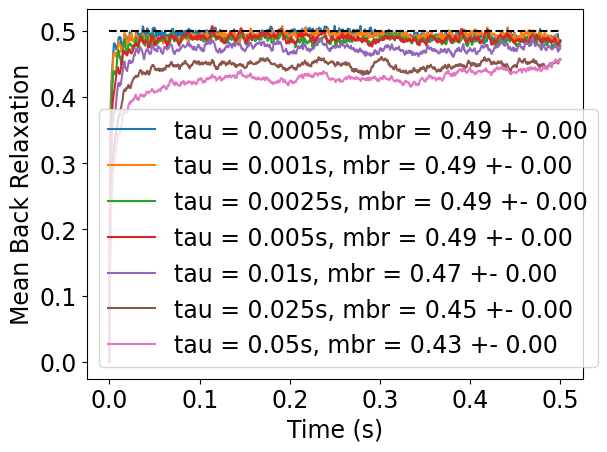

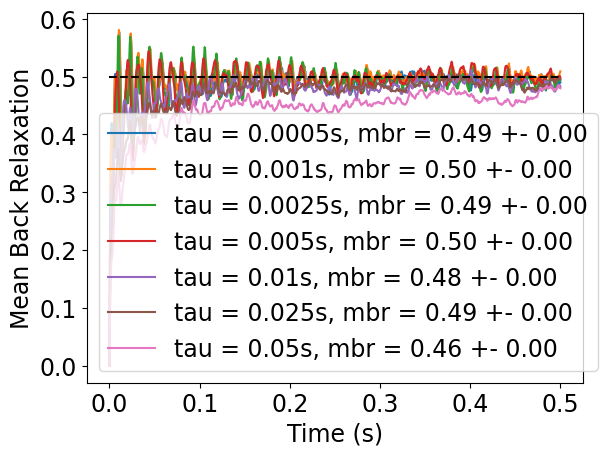

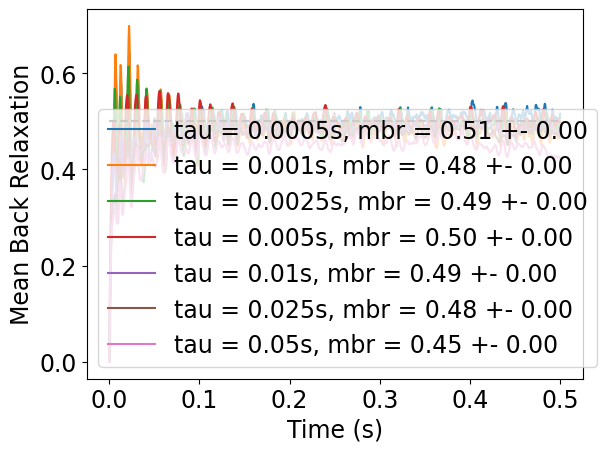

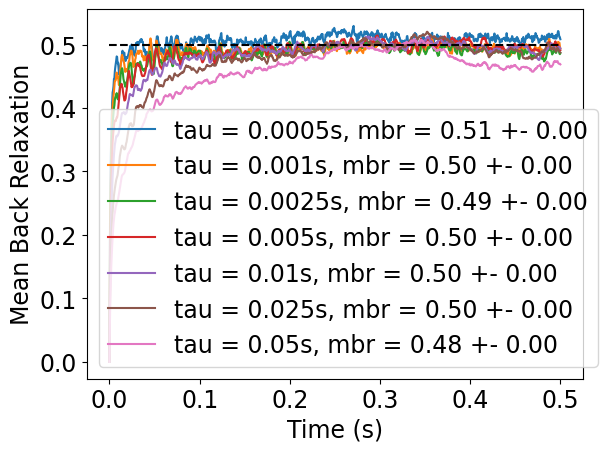

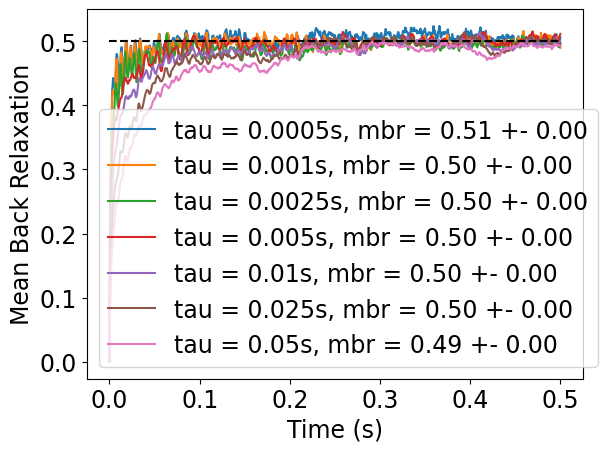

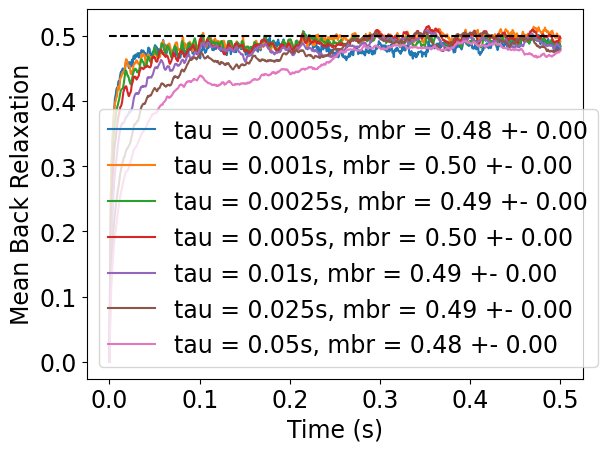

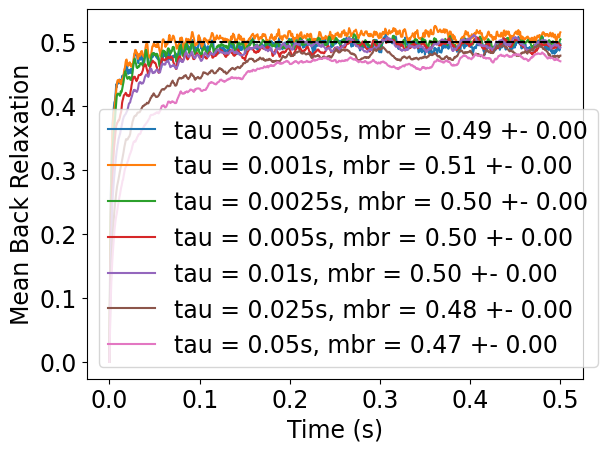

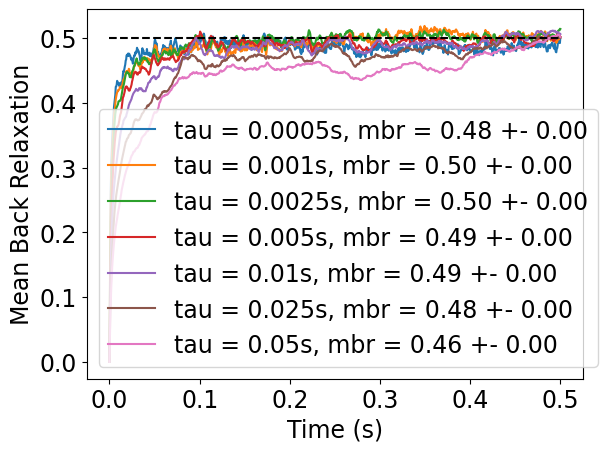

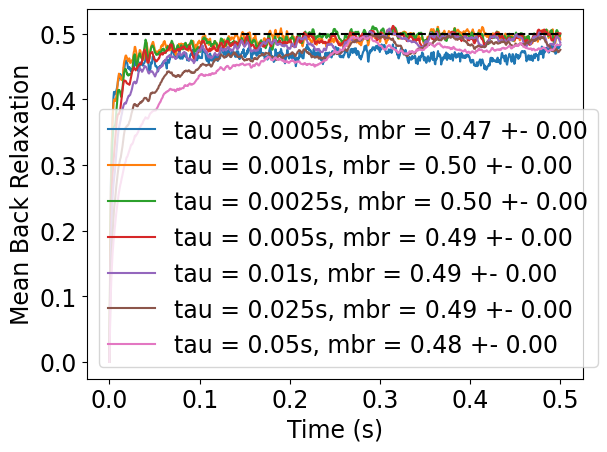

In [24]:
for i in range(len(mbr_list[0])):
    plt.figure()
    for j in range(len(mbr_list)):
        second_half_mbr = mbr_list[j][i][int(len(mbr_list[j][i])/2):]
        mean_longtime = np.mean(second_half_mbr)
        sigma_longtime = np.std(second_half_mbr)/np.sqrt(len(second_half_mbr))
        plt.plot(t_mbr, mbr_list[j][i], label =f'tau = {tau_list[j]}s, mbr = {mean_longtime:.2f} +- {sigma_longtime:.2f}')
    plt.plot(t_mbr,np.ones_like(t_mbr)*.5, c='black', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Back Relaxation')
    plt.legend()
    plt.show()

\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_1\2_kHz.avi


100%|██████████| 96513/96513 [00:00<00:00, 283349.60it/s]


\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_2\2_kHz.avi


100%|██████████| 83211/83211 [00:00<00:00, 297749.07it/s]


\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_3\2_kHz.avi


100%|██████████| 10285/10285 [00:00<00:00, 250643.00it/s]


\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_4\2_kHz.avi


100%|██████████| 34633/34633 [00:00<00:00, 186555.60it/s]


\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_5\2_kHz.avi


100%|██████████| 39019/39019 [00:00<00:00, 330805.09it/s]


\\134.76.13.158\betzlab\Julian\cell_beats\11_03_24\sample_6\2_kHz.avi


100%|██████████| 38121/38121 [00:00<00:00, 333250.79it/s]


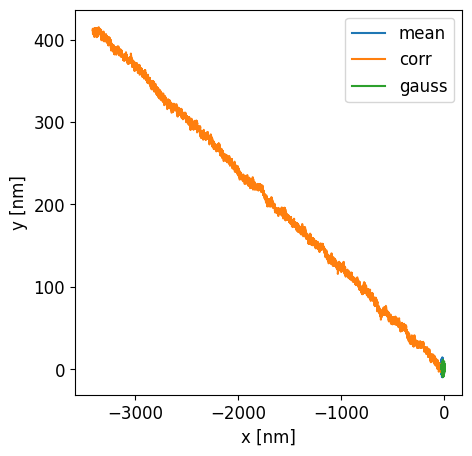

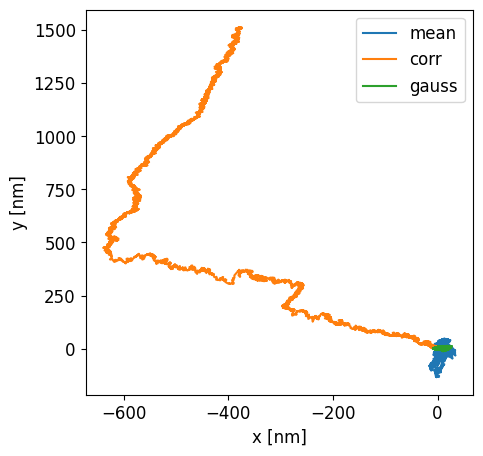

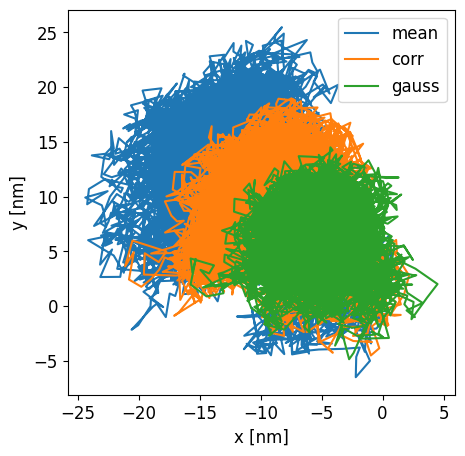

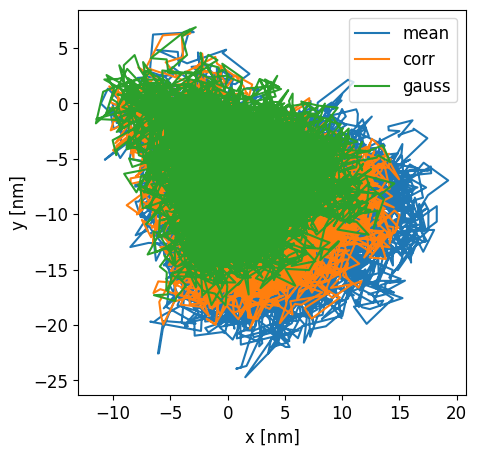

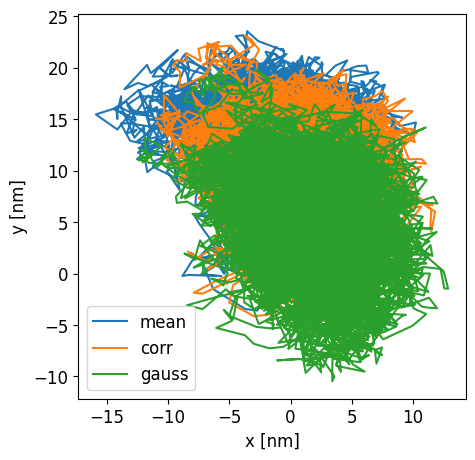

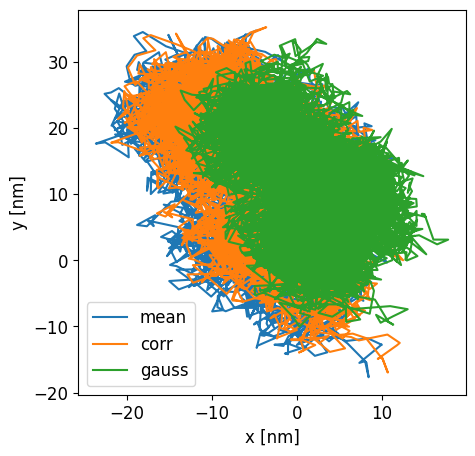

In [41]:

dt = 1/2000
T = .05
tau = dt*20
guass_mbr_list = []
for path in two_khz_path_list:
    print(path)
    tra_mean = np.load(os.path.join(os.path.dirname(path), '2_khz_trajectories', 'tra_mean.npy'))
    tra_gauss = np.load(os.path.join(os.path.dirname(path), '2_khz_trajectories', 'tra_gauss.npy'))
    tra_corr = np.load(os.path.join(os.path.dirname(path), '2_khz_trajectories', 'tra_corr.npy'))

    guass_mbr_list.append(mean_back_realxation(dt,tra_corr[:,0],tau,T))

    plt.rcParams['figure.figsize'] = (5, 5)  # Adjust the size as desired
    # Set the font size
    font_size = 12  # Adjust the font size as desired
    plt.rcParams.update({'font.size': font_size})

    n_steps = 10000
    # Plot the data
    plt.figure()
    pixel_size_in_nm = 36.7
    plt.plot(tra_mean[:n_steps,0]*pixel_size_in_nm,tra_mean[:n_steps,1]*pixel_size_in_nm,label='mean') 
    plt.plot(tra_corr[:n_steps,0]*pixel_size_in_nm,tra_corr[:n_steps,1]*pixel_size_in_nm,label='corr')
    #plt.plot(tra_corr[:n_steps,0]*pixel_size_in_nm,tra_corr[:n_steps,1]*pixel_size_in_nm,label='corr')
    plt.plot(tra_gauss[:n_steps,0]*pixel_size_in_nm,tra_gauss[:n_steps,1]*pixel_size_in_nm,label='gauss')
    plt.legend()
    plt.xlabel('x [nm]')
    plt.ylabel('y [nm]')

In [25]:
good_data = data_list[2]
good_mbr = mean_back_realxation(dt,good_data.reconstructed_x,tau,T)

100%|██████████| 35137/35137 [00:00<00:00, 213667.54it/s]
